Reading and Parsing the Dataset


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.ar_model import AutoReg
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
df = pd.read_csv("covidcast_new-1.csv", parse_dates=["time_value"])
df["geo_value"] = df["geo_value"].astype("category")


In [3]:
df.columns

Index(['time_value', 'geo_value', 'smoothed_wspent_time_1d',
       'smoothed_wtested_14d', 'smoothed_wpublic_transit_1d',
       'smoothed_wworried_become_ill', 'smoothed_wvaccine_likely_govt_health',
       'smoothed_wshop_1d', 'smoothed_wtested_positive_14d',
       'smoothed_wwork_outside_home_1d', 'smoothed_wothers_masked',
       'smoothed_wcli', 'smoothed_wcovid_vaccinated',
       'smoothed_wvaccine_likely_friends', 'smoothed_wrestaurant_1d',
       'smoothed_wvaccine_likely_politicians', 'smoothed_wvaccine_likely_who',
       'smoothed_wwearing_mask', 'smoothed_wlarge_event_1d'],
      dtype='object')

3.2 Dropping Columns with Excessive Missingness

In [4]:
missing_frac = df.isna().mean()
to_drop = missing_frac[(missing_frac > 0.5) & (missing_frac.index != "smoothed_wtested_positive_14d")].index.tolist()
df.drop(columns=to_drop, inplace=True)


Time-Series Interpolation for Remaining Missing Values

In [5]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

def impute_group(group):
    g = group.set_index("time_value")
    g[numeric_cols] = (
        g[numeric_cols]
        .interpolate(method="time")
        .ffill()
        .bfill()
    )
    return g.reset_index()

df = df.groupby("geo_value", group_keys=False, observed=True).apply(impute_group)


C:\Users\abhin\AppData\Local\Temp\ipykernel_12928\1906032865.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("geo_value", group_keys=False, observed=True).apply(impute_group)


3.4 Outlier Capping

In [6]:
for col in numeric_cols:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df[col] = df[col].clip(lower, upper)


3.5 Feature Scaling

In [7]:
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


In [8]:
df

,time_value,geo_value,smoothed_wspent_time_1d,smoothed_wtested_14d,smoothed_wpublic_transit_1d,smoothed_wworried_become_ill,smoothed_wvaccine_likely_govt_health,smoothed_wshop_1d,smoothed_wtested_positive_14d,smoothed_wwork_outside_home_1d,smoothed_wothers_masked,smoothed_wcli,smoothed_wcovid_vaccinated,smoothed_wvaccine_likely_friends,smoothed_wrestaurant_1d,smoothed_wvaccine_likely_politicians,smoothed_wvaccine_likely_who,smoothed_wwearing_mask,smoothed_wlarge_event_1d
0,2021-01-07,1000,0.411582,-0.123378,-0.675735,-0.483531,-1.291482,-0.128659,1.680391,-0.574072,-1.856407,3.162857,-1.581121,-1.069153,0.522590,-0.130499,-1.450813,-1.437684,0.974467
1,2021-01-08,1000,0.162720,-0.050244,-0.620601,-0.414166,-1.353231,-0.141609,1.860651,-0.521343,-1.850888,3.155606,-1.581121,-0.887620,0.220516,-0.185322,-1.391842,-1.225674,0.692173
2,2021-01-09,1000,0.057931,-0.109108,-0.348023,-0.545068,-1.300732,-0.120549,2.074409,-0.043900,-1.979894,3.108360,-1.429626,-0.727438,0.297637,-0.226540,-1.383557,-1.273305,0.832899
3,2021-01-10,1000,-0.171683,0.048333,-0.459055,-0.542792,-1.232818,-0.281239,2.243027,0.000434,-1.869965,2.795575,-1.391826,-0.655612,0.261539,-0.108139,-1.216523,-1.087861,0.779045
4,2021-01-11,1000,-0.334598,0.432504,-0.556367,-0.422972,-1.364217,-0.502807,2.093033,-0.233219,-1.769934,3.143946,-1.332422,-0.621585,0.095813,-0.218438,-1.376541,-0.968373,0.519299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,2021-02-08,56025,2.680199,-0.808120,-0.027296,-1.752510,-0.863675,1.580117,NaN,2.517720,-2.529274,-1.548320,0.921831,-0.682613,2.300794,-1.484577,-2.102475,-2.286494,2.773178
30,2021-02-09,56025,2.680199,-1.162324,-0.312449,-1.752510,-0.863675,1.372373,NaN,2.517720,-2.529274,-1.548320,0.983327,-0.682613,2.195212,-1.484577,-2.102475,-2.286494,2.667494
31,2021-02-10,56025,2.680199,-1.081296,-0.597601,-1.752510,-0.863675,1.164629,NaN,2.517720,-2.529274,-1.548320,1.044823,-0.682613,2.089630,-1.484577,-2.102475,-2.286494,2.561810
32,2021-02-11,56025,2.680199,-1.598749,-0.882754,-1.752510,-0.863675,0.956885,NaN,2.517720,-2.529274,-1.548320,1.038682,-0.682613,1.984048,-1.484577,-2.102475,-2.286494,2.456126


3.6 Multicollinearity Check

In [9]:
corr = df[numeric_cols].corr().abs()
high_corr_pairs = [
    (corr.index[i], corr.columns[j], corr.iloc[i, j])
    for i, j in zip(*np.where(np.triu(corr.values, k=1) > 0.9))
]


In [10]:
print(df.shape)


(25626, 19)


EDA

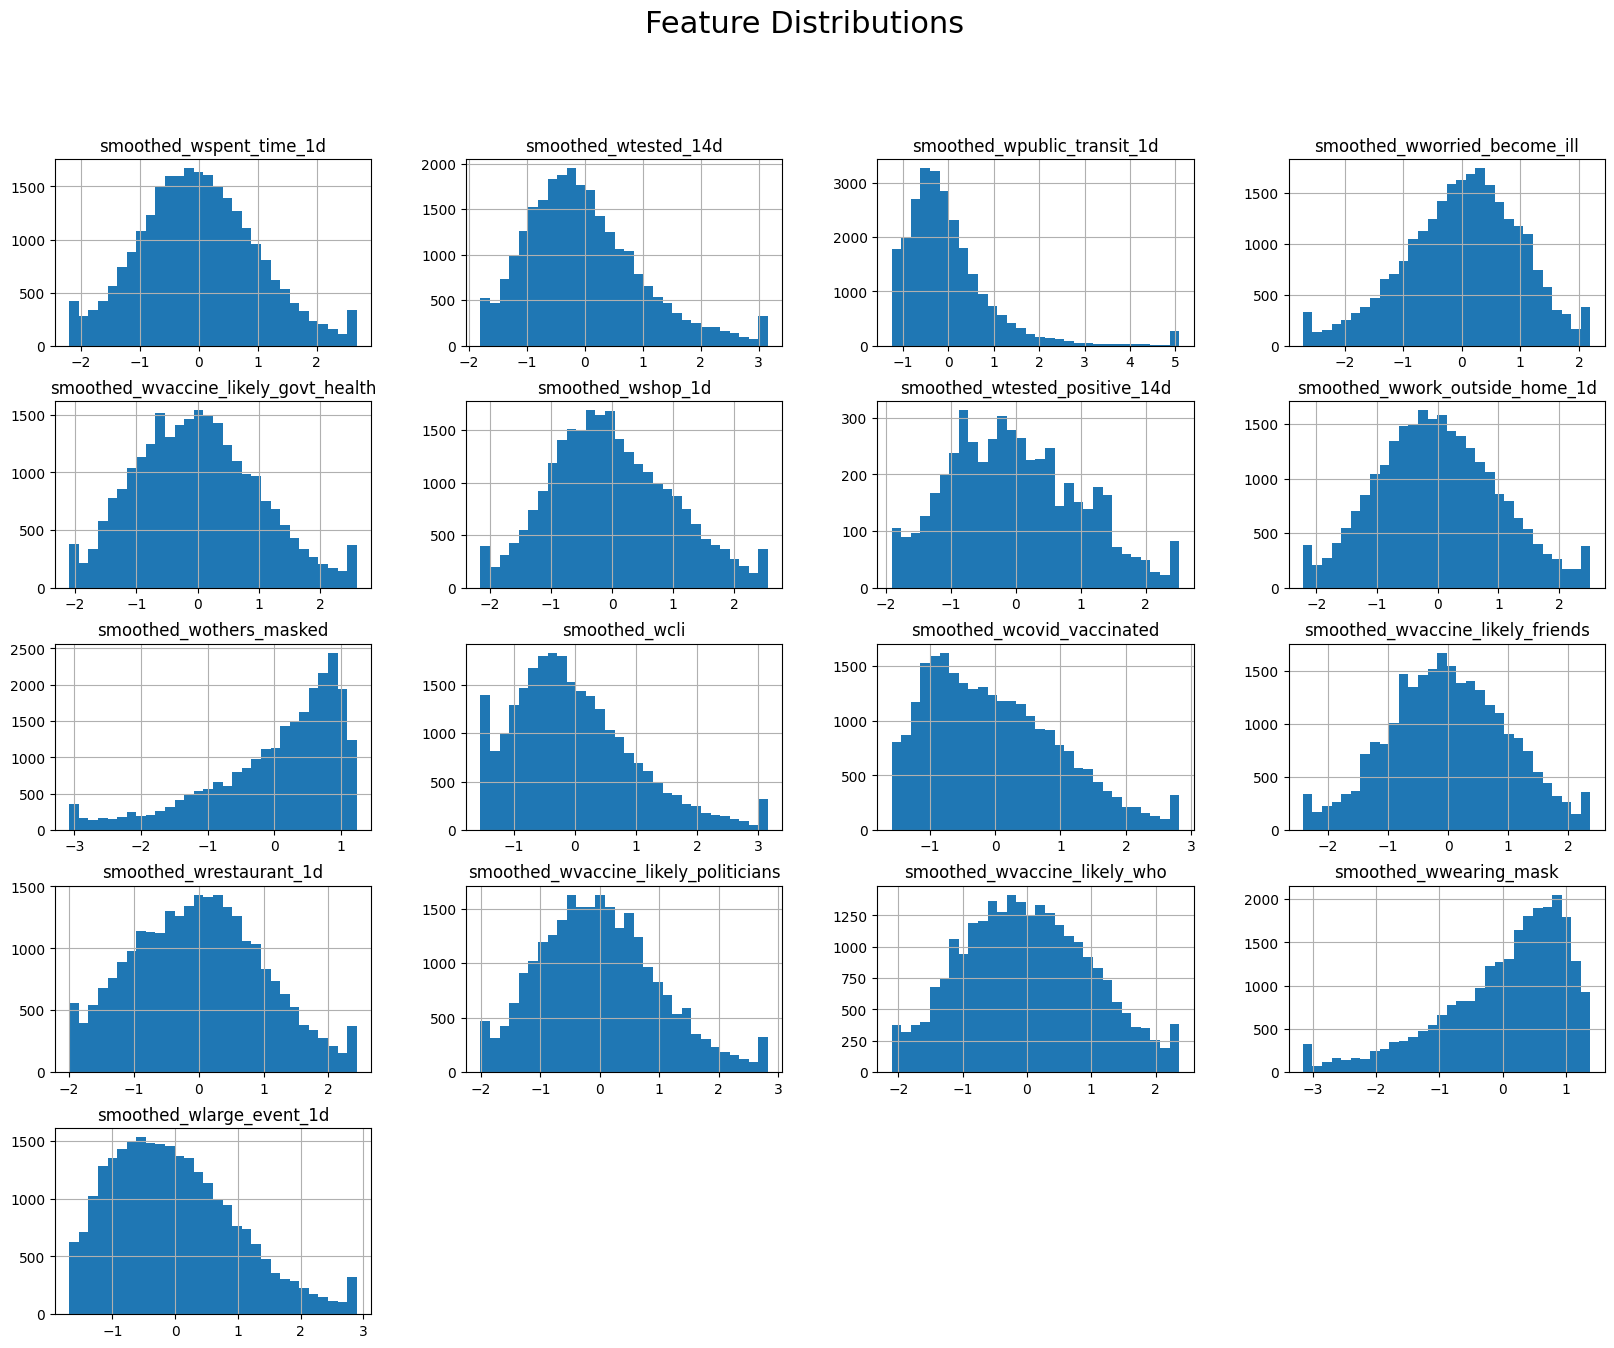

In [11]:
df[numeric_cols].hist(bins=30, figsize=(20, 15))
plt.suptitle("Feature Distributions", fontsize=22)
plt.show()


4.2 Correlation Heatmap

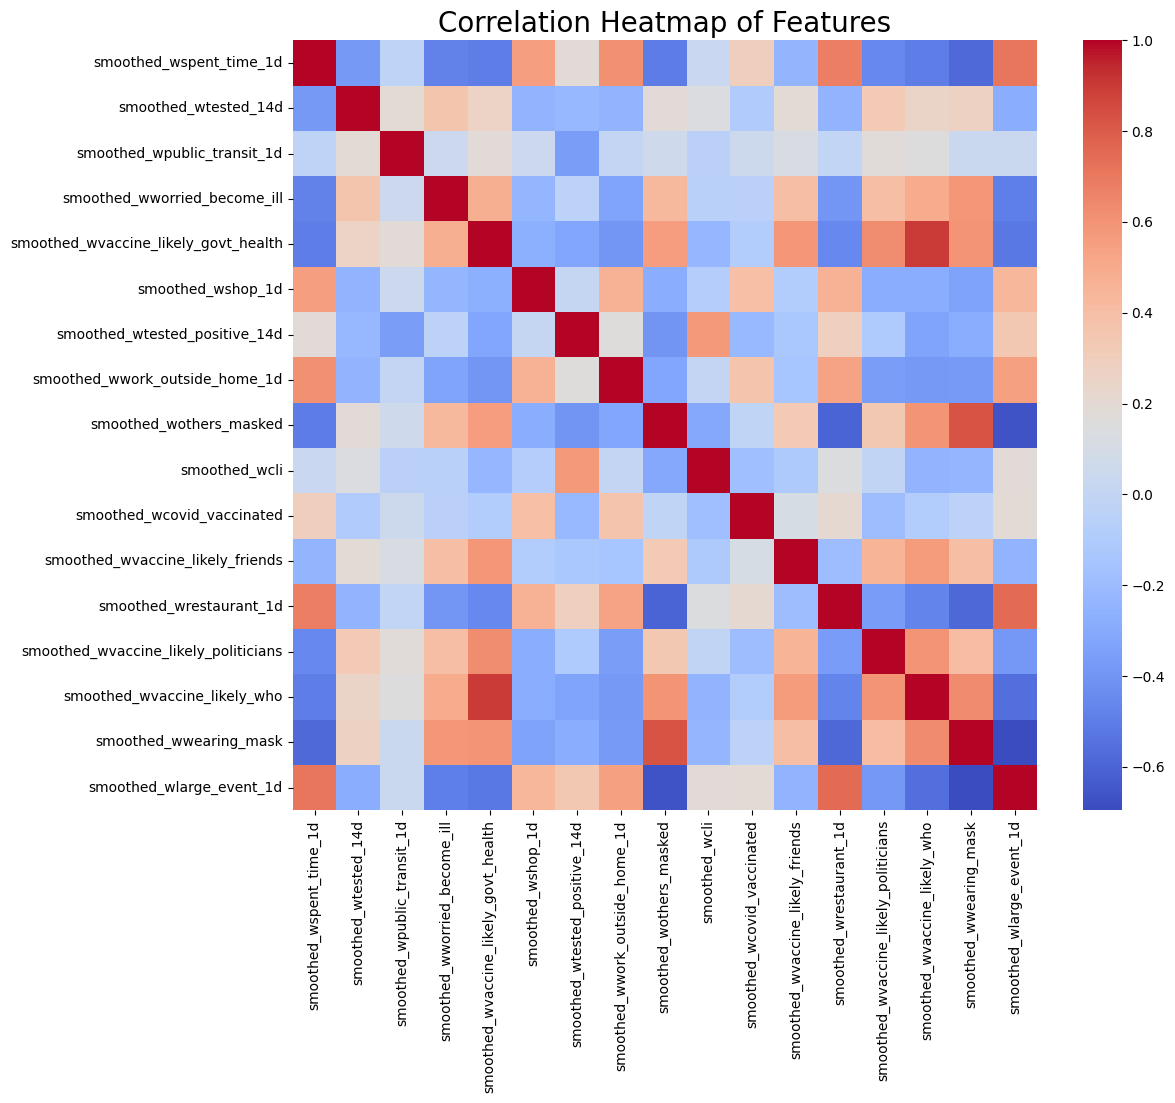

In [12]:
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(df[numeric_cols].corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap of Features", fontsize=20)
plt.show()


5.1 Behavioral Compliance Index

In [13]:
df["behavioral_compliance_index"] = (
    df["smoothed_wwearing_mask"] +
    df["smoothed_wcovid_vaccinated"] +
    df["smoothed_wvaccine_likely_govt_health"] +
    df["smoothed_wvaccine_likely_who"]
) / 4


5.2 Social Exposure Score

In [14]:
df["social_exposure_score"] = (
    df["smoothed_wrestaurant_1d"] +
    df["smoothed_wshop_1d"] +
    df["smoothed_wpublic_transit_1d"] +
    df["smoothed_wwork_outside_home_1d"] +
    df["smoothed_wlarge_event_1d"]
) / 5


5.3 Mistrust Gap

In [15]:
df["mistrust_gap"] = (
    df["smoothed_wvaccine_likely_govt_health"] +
    df["smoothed_wvaccine_likely_who"]
) - df["smoothed_wvaccine_likely_politicians"]


5.4 Peer Influence Index

In [16]:
df["peer_influence_index"] = (
    df["smoothed_wothers_masked"] +
    df["smoothed_wvaccine_likely_friends"]
) / 2


5.5 CLI Risk Behavior Flag

In [17]:
df["cli_risk_flag"] = np.where(
    (df["smoothed_wcli"] > df["smoothed_wcli"].quantile(0.75)) &
    (df["behavioral_compliance_index"] < df["behavioral_compliance_index"].quantile(0.25)),
    1, 0
)


For Predicting smoothed_wcovid_vaccinated

In [18]:
vax_features = [
    "behavioral_compliance_index",
    "peer_influence_index",
    "mistrust_gap",
    "smoothed_wworried_become_ill",
    "social_exposure_score",
]


For Predicting smoothed_wtested_positive_14d (COVID Positivity Rate)

In [19]:
case_features = [
    "social_exposure_score",
    "smoothed_wwearing_mask",
    "smoothed_wothers_masked",
    "smoothed_wcli",
    "smoothed_wtested_14d",
    "smoothed_wcovid_vaccinated",
    "cli_risk_flag"
]


Correlation with Targets

In [20]:
corr_vax = df[vax_features + ["smoothed_wcovid_vaccinated"]].corr()
print(corr_vax["smoothed_wcovid_vaccinated"].sort_values(ascending=False))


smoothed_wcovid_vaccinated      1.000000
social_exposure_score           0.355099
behavioral_compliance_index     0.280237
peer_influence_index            0.055002
mistrust_gap                    0.011663
smoothed_wworried_become_ill   -0.048824
Name: smoothed_wcovid_vaccinated, dtype: float64


COVID Positivity Correlation:



In [21]:
corr_case = df[case_features + ["smoothed_wtested_positive_14d"]].corr()
print(corr_case["smoothed_wtested_positive_14d"].sort_values(ascending=False))


smoothed_wtested_positive_14d    1.000000
smoothed_wcli                    0.570537
cli_risk_flag                    0.347854
social_exposure_score            0.076792
smoothed_wcovid_vaccinated      -0.213622
smoothed_wtested_14d            -0.223603
smoothed_wwearing_mask          -0.283770
smoothed_wothers_masked         -0.401740
Name: smoothed_wtested_positive_14d, dtype: float64


## Modelling

In [22]:
# Dataset for vaccine uptake
df_vaccine = df.copy()

# Dataset for COVID test positivity rate
df_test_positive = df.copy()

In [23]:
# Drop rows where the vaccine uptake target is missing
df_vaccine = df_vaccine.dropna(subset=['smoothed_wcovid_vaccinated'])

# Drop rows where the COVID positivity rate target is missing
df_test_positive = df_test_positive.dropna(subset=['smoothed_wtested_positive_14d'])


In [24]:
# For df_vaccine
for col in df_vaccine.columns:
    if df_vaccine[col].isnull().sum() > 0:
        if df_vaccine[col].dtype in ['float64', 'int64']:
            df_vaccine[col] = df_vaccine[col].fillna(df_vaccine[col].median())
        else:
            df_vaccine[col] = df_vaccine[col].fillna(df_vaccine[col].mode()[0])

# For df_test_positive
for col in df_test_positive.columns:
    if df_test_positive[col].isnull().sum() > 0:
        if df_test_positive[col].dtype in ['float64', 'int64']:
            df_test_positive[col] = df_test_positive[col].fillna(df_test_positive[col].median())
        else:
            df_test_positive[col] = df_test_positive[col].fillna(df_test_positive[col].mode()[0])


In [25]:
df_vaccine.to_csv('vaccine_dataset.csv', index=False)
df_test_positive.to_csv('test_positive_dataset.csv', index=False)

In [26]:
print("Number of rows in Vaccine Dataset:", len(df_vaccine))
print("Number of rows in Test Positivity Dataset:", len(df_test_positive))

Number of rows in Vaccine Dataset: 25478
Number of rows in Test Positivity Dataset: 4951


In [27]:
print("Columns in Vaccine Dataset:")
print(df_vaccine.columns.tolist())

print("\nColumns in Test Positivity Dataset:")
print(df_test_positive.columns.tolist())

Columns in Vaccine Dataset:
['time_value', 'geo_value', 'smoothed_wspent_time_1d', 'smoothed_wtested_14d', 'smoothed_wpublic_transit_1d', 'smoothed_wworried_become_ill', 'smoothed_wvaccine_likely_govt_health', 'smoothed_wshop_1d', 'smoothed_wtested_positive_14d', 'smoothed_wwork_outside_home_1d', 'smoothed_wothers_masked', 'smoothed_wcli', 'smoothed_wcovid_vaccinated', 'smoothed_wvaccine_likely_friends', 'smoothed_wrestaurant_1d', 'smoothed_wvaccine_likely_politicians', 'smoothed_wvaccine_likely_who', 'smoothed_wwearing_mask', 'smoothed_wlarge_event_1d', 'behavioral_compliance_index', 'social_exposure_score', 'mistrust_gap', 'peer_influence_index', 'cli_risk_flag']

Columns in Test Positivity Dataset:
['time_value', 'geo_value', 'smoothed_wspent_time_1d', 'smoothed_wtested_14d', 'smoothed_wpublic_transit_1d', 'smoothed_wworried_become_ill', 'smoothed_wvaccine_likely_govt_health', 'smoothed_wshop_1d', 'smoothed_wtested_positive_14d', 'smoothed_wwork_outside_home_1d', 'smoothed_wothers_m

To evaluate model performance effectively, we divided the dataset into training and testing sets using a time-based approach. We trained the model on data up to February 5, 2021, and tested it on data afterward. This method simulates real-world scenarios, where we predict future outcomes based on past data, while avoiding information leakage.

However, one limitation is that distribution shifts due to policy changes, seasonal effects, or behavioral changes in the population could affect model performance.

In [28]:
split_date_1 = '2021-02-05'  # First split (train/val)
split_date_2 = '2021-02-09'  # Second split (val/test)

# Vaccine dataset splits
df_vaccine_train = df_vaccine[df_vaccine['time_value'] < split_date_1]
df_vaccine_val = df_vaccine[(df_vaccine['time_value'] >= split_date_1) & (df_vaccine['time_value'] < split_date_2)]
df_vaccine_test = df_vaccine[df_vaccine['time_value'] >= split_date_2]

# Test positivity dataset splits
df_test_positive_train = df_test_positive[df_test_positive['time_value'] < split_date_1]
df_test_positive_val = df_test_positive[(df_test_positive['time_value'] >= split_date_1) & (df_test_positive['time_value'] < split_date_2)]
df_test_positive_test = df_test_positive[df_test_positive['time_value'] >= split_date_2]

vaccine_target = 'smoothed_wcovid_vaccinated'
test_positive_target = 'smoothed_wtested_positive_14d'
# Feature selection
vaccine_features = df_vaccine.columns.drop(['time_value', 'geo_value', vaccine_target, 'smoothed_wtested_positive_14d'])
test_positive_features = df_test_positive.columns.drop(['time_value', 'geo_value', test_positive_target, 'smoothed_wcovid_vaccinated'])

# Vaccine dataset
X_vaccine_train = df_vaccine_train[vaccine_features]
y_vaccine_train = df_vaccine_train[vaccine_target]
X_vaccine_val = df_vaccine_val[vaccine_features]
y_vaccine_val = df_vaccine_val[vaccine_target]
X_vaccine_test = df_vaccine_test[vaccine_features]
y_vaccine_test = df_vaccine_test[vaccine_target]

# Test positivity dataset
X_test_positive_train = df_test_positive_train[test_positive_features]
y_test_positive_train = df_test_positive_train[test_positive_target]
X_test_positive_val = df_test_positive_val[test_positive_features]
y_test_positive_val = df_test_positive_val[test_positive_target]
X_test_positive_test = df_test_positive_test[test_positive_features]
y_test_positive_test = df_test_positive_test[test_positive_target]



In [29]:
# Vaccine dataset stats
total_vaccine_samples = X_vaccine_train.shape[0] + X_vaccine_val.shape[0] + X_vaccine_test.shape[0]
vaccine_train_percentage = (X_vaccine_train.shape[0] / total_vaccine_samples) * 100
vaccine_val_percentage = (X_vaccine_val.shape[0] / total_vaccine_samples) * 100
vaccine_test_percentage = (X_vaccine_test.shape[0] / total_vaccine_samples) * 100

print("=== Vaccine Uptake Dataset ===")
print(f"Total samples: {total_vaccine_samples}")
print(f"Training samples: {X_vaccine_train.shape[0]} ({vaccine_train_percentage:.2f}%)")
print(f"Validation samples: {X_vaccine_val.shape[0]} ({vaccine_val_percentage:.2f}%)")
print(f"Testing samples: {X_vaccine_test.shape[0]} ({vaccine_test_percentage:.2f}%)\n")

# Test positivity dataset stats
total_test_positive_samples = X_test_positive_train.shape[0] + X_test_positive_val.shape[0] + X_test_positive_test.shape[0]
test_positive_train_percentage = (X_test_positive_train.shape[0] / total_test_positive_samples) * 100
test_positive_val_percentage = (X_test_positive_val.shape[0] / total_test_positive_samples) * 100
test_positive_test_percentage = (X_test_positive_test.shape[0] / total_test_positive_samples) * 100

print("=== Test Positivity Dataset ===")
print(f"Total samples: {total_test_positive_samples}")
print(f"Training samples: {X_test_positive_train.shape[0]} ({test_positive_train_percentage:.2f}%)")
print(f"Validation samples: {X_test_positive_val.shape[0]} ({test_positive_val_percentage:.2f}%)")
print(f"Testing samples: {X_test_positive_test.shape[0]} ({test_positive_test_percentage:.2f}%)")


=== Vaccine Uptake Dataset ===
Total samples: 25478
Training samples: 20363 (79.92%)
Validation samples: 2533 (9.94%)
Testing samples: 2582 (10.13%)

=== Test Positivity Dataset ===
Total samples: 4951
Training samples: 3881 (78.39%)
Validation samples: 534 (10.79%)
Testing samples: 536 (10.83%)


In [30]:
# Check missing values for Vaccine dataset
print("=== Missing Values in Vaccine Uptake Dataset ===")
print("\nTraining features missing values:")
print(X_vaccine_train.isnull().sum()[X_vaccine_train.isnull().sum() > 0])

print("\nValidation features missing values:")
print(X_vaccine_val.isnull().sum()[X_vaccine_val.isnull().sum() > 0])

print("\nTesting features missing values:")
print(X_vaccine_test.isnull().sum()[X_vaccine_test.isnull().sum() > 0])

# Check missing values for Test positivity dataset
print("\n=== Missing Values in Test Positivity Dataset ===")
print("\nTraining features missing values:")
print(X_test_positive_train.isnull().sum()[X_test_positive_train.isnull().sum() > 0])

print("\nValidation features missing values:")
print(X_test_positive_val.isnull().sum()[X_test_positive_val.isnull().sum() > 0])

print("\nTesting features missing values:")
print(X_test_positive_test.isnull().sum()[X_test_positive_test.isnull().sum() > 0])


=== Missing Values in Vaccine Uptake Dataset ===

Training features missing values:
Series([], dtype: int64)

Validation features missing values:
Series([], dtype: int64)

Testing features missing values:
Series([], dtype: int64)

=== Missing Values in Test Positivity Dataset ===

Training features missing values:
Series([], dtype: int64)

Validation features missing values:
Series([], dtype: int64)

Testing features missing values:
Series([], dtype: int64)


In [31]:
def train_and_evaluate_full(X_train, y_train, X_val, y_val, X_test, y_test, model):
    model.fit(X_train, y_train)

    # Predict on all sets
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # Calculate metrics
    metrics = {
        'train': {
            'r2': r2_score(y_train, y_train_pred),
            'rmse': np.sqrt(mean_squared_error(y_train, y_train_pred))
        },
        'val': {
            'r2': r2_score(y_val, y_val_pred),
            'rmse': np.sqrt(mean_squared_error(y_val, y_val_pred))
        },
        'test': {
            'r2': r2_score(y_test, y_test_pred),
            'rmse': np.sqrt(mean_squared_error(y_test, y_test_pred))
        }
    }
    return metrics

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(alpha=0.1),
    "Ridge Regression": Ridge(alpha=1.0)
}

def print_metrics(metrics, indent=2):
    spaces = ' ' * indent
    print(f"{spaces}Train -> R² = {metrics['train']['r2']:.4f}, RMSE = {metrics['train']['rmse']:.4f}")
    print(f"{spaces}Val   -> R² = {metrics['val']['r2']:.4f}, RMSE = {metrics['val']['rmse']:.4f}")
    print(f"{spaces}Test  -> R² = {metrics['test']['r2']:.4f}, RMSE = {metrics['test']['rmse']:.4f}")

# Vaccine Uptake Prediction
print("=== Vaccine Uptake Prediction ===")
for name, model in models.items():
    metrics = train_and_evaluate_full(
        X_vaccine_train, y_vaccine_train,
        X_vaccine_val, y_vaccine_val,
        X_vaccine_test, y_vaccine_test,
        model
    )
    print(f"{name}:")
    print_metrics(metrics)
    print()

# Test Positivity Prediction
print("\n=== Test Positivity Prediction ===")
for name, model in models.items():
    metrics = train_and_evaluate_full(
        X_test_positive_train, y_test_positive_train,
        X_test_positive_val, y_test_positive_val,
        X_test_positive_test, y_test_positive_test,
        model
    )
    print(f"{name}:")
    print_metrics(metrics)
    print()


=== Vaccine Uptake Prediction ===
Linear Regression:
  Train -> R² = 0.9323, RMSE = 0.2195
  Val   -> R² = 0.9665, RMSE = 0.1387
  Test  -> R² = 0.9430, RMSE = 0.1829

Lasso Regression:
  Train -> R² = 0.1909, RMSE = 0.7589
  Val   -> R² = -1.6701, RMSE = 1.2391
  Test  -> R² = -2.6452, RMSE = 1.4627

Ridge Regression:
  Train -> R² = 0.9310, RMSE = 0.2216
  Val   -> R² = 0.9666, RMSE = 0.1386
  Test  -> R² = 0.9412, RMSE = 0.1858


=== Test Positivity Prediction ===
Linear Regression:
  Train -> R² = 0.5874, RMSE = 0.6510
  Val   -> R² = 0.5065, RMSE = 0.6389
  Test  -> R² = 0.3970, RMSE = 0.6674

Lasso Regression:
  Train -> R² = 0.4236, RMSE = 0.7693
  Val   -> R² = 0.2156, RMSE = 0.8056
  Test  -> R² = 0.1297, RMSE = 0.8018

Ridge Regression:
  Train -> R² = 0.5823, RMSE = 0.6550
  Val   -> R² = 0.5121, RMSE = 0.6353
  Test  -> R² = 0.3931, RMSE = 0.6695



## We reject the Lasso Regression after this for poor perfromance. We do a hyperparameter selection for alpha for Ridge Regression.

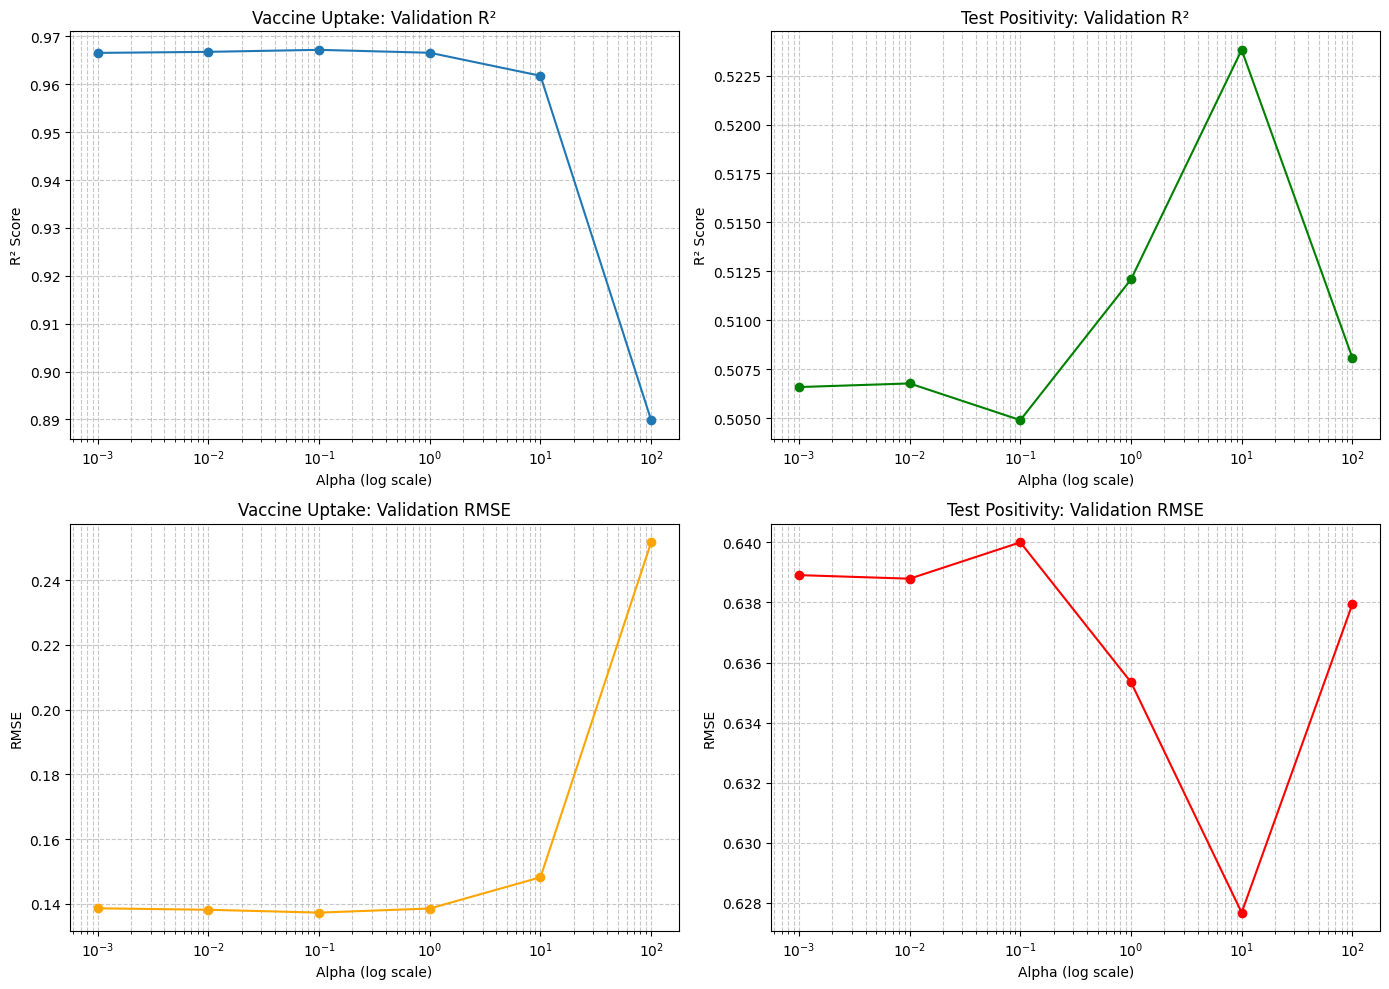


=== Best Hyperparameters ===
Vaccine Uptake:
 Best Alpha: 0.1 (Val RMSE = 0.1373)
 Test R² = 0.9426, Test RMSE = 0.1835

Test Positivity:
 Best Alpha: 10.0 (Val RMSE = 0.6277)
 Test R² = 0.4041, Test RMSE = 0.6634


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error

def train_and_evaluate_ridge(X_train, y_train, X_val, y_val, alpha):
    """Train on training data, evaluate on validation data"""
    model = Ridge(alpha=alpha, random_state=42)
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    return (
        r2_score(y_val, y_val_pred),
        np.sqrt(mean_squared_error(y_val, y_val_pred))
    )

# Define range of alpha values to test
alpha_values = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

# Dictionary to store VALIDATION results
ridge_results = {"vaccine": [], "test_positivity": []}

# ===== Hyperparameter Tuning (using validation set) =====
# Vaccine Uptake
for alpha in alpha_values:
    r2_val, rmse_val = train_and_evaluate_ridge(
        X_vaccine_train, y_vaccine_train,
        X_vaccine_val, y_vaccine_val,
        alpha
    )
    ridge_results["vaccine"].append((alpha, r2_val, rmse_val))

# Test Positivity
for alpha in alpha_values:
    r2_val, rmse_val = train_and_evaluate_ridge(
        X_test_positive_train, y_test_positive_train,
        X_test_positive_val, y_test_positive_val,
        alpha
    )
    ridge_results["test_positivity"].append((alpha, r2_val, rmse_val))

# ===== Plotting Validation Performance =====
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Vaccine Uptake plots
vaccine_results = ridge_results["vaccine"]
alphas_vaccine, r2_vaccine, rmse_vaccine = zip(*vaccine_results)

axes[0, 0].semilogx(alphas_vaccine, r2_vaccine, 'o-', label='Vaccine Uptake')
axes[0, 0].set_xlabel('Alpha (log scale)')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].set_title('Vaccine Uptake: Validation R²')
axes[0, 0].grid(True, which='both', linestyle='--', alpha=0.7)

axes[1, 0].semilogx(alphas_vaccine, rmse_vaccine, 'o-', color='orange', label='Vaccine Uptake')
axes[1, 0].set_xlabel('Alpha (log scale)')
axes[1, 0].set_ylabel('RMSE')
axes[1, 0].set_title('Vaccine Uptake: Validation RMSE')
axes[1, 0].grid(True, which='both', linestyle='--', alpha=0.7)

# Test Positivity plots
test_pos_results = ridge_results["test_positivity"]
alphas_test, r2_test, rmse_test = zip(*test_pos_results)

axes[0, 1].semilogx(alphas_test, r2_test, 'o-', label='Test Positivity', color='green')
axes[0, 1].set_xlabel('Alpha (log scale)')
axes[0, 1].set_ylabel('R² Score')
axes[0, 1].set_title('Test Positivity: Validation R²')
axes[0, 1].grid(True, which='both', linestyle='--', alpha=0.7)

axes[1, 1].semilogx(alphas_test, rmse_test, 'o-', color='red', label='Test Positivity')
axes[1, 1].set_xlabel('Alpha (log scale)')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].set_title('Test Positivity: Validation RMSE')
axes[1, 1].grid(True, which='both', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# ===== Final Evaluation on Test Set =====
def evaluate_final(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return (
        r2_score(y_test, y_pred),
        np.sqrt(mean_squared_error(y_test, y_pred))
    )

# Find best alpha based on VALIDATION performance (lowest RMSE)
best_ridge_vaccine = min(ridge_results["vaccine"], key=lambda x: x[2])
best_ridge_test = min(ridge_results["test_positivity"], key=lambda x: x[2])

# Train final models with best alpha and evaluate on TEST set
final_vaccine_model = Ridge(alpha=best_ridge_vaccine[0], random_state=42)
r2_test_vaccine, rmse_test_vaccine = evaluate_final(
    final_vaccine_model,
    X_vaccine_train, y_vaccine_train,
    X_vaccine_test, y_vaccine_test
)

final_test_model = Ridge(alpha=best_ridge_test[0], random_state=42)
r2_test_pos, rmse_test_pos = evaluate_final(
    final_test_model,
    X_test_positive_train, y_test_positive_train,
    X_test_positive_test, y_test_positive_test
)

# ===== Results Summary =====
print("\n=== Best Hyperparameters ===")
print(f"Vaccine Uptake:")
print(f" Best Alpha: {best_ridge_vaccine[0]} (Val RMSE = {best_ridge_vaccine[2]:.4f})")
print(f" Test R² = {r2_test_vaccine:.4f}, Test RMSE = {rmse_test_vaccine:.4f}\n")

print(f"Test Positivity:")
print(f" Best Alpha: {best_ridge_test[0]} (Val RMSE = {best_ridge_test[2]:.4f})")
print(f" Test R² = {r2_test_pos:.4f}, Test RMSE = {rmse_test_pos:.4f}")


### We look at two more models as we are getting very bad results for Test positivity.

In [33]:
# Random Forest model
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

# ===== Vaccine Uptake Prediction =====
random_forest_model.fit(X_vaccine_train, y_vaccine_train)

# Predictions
y_vaccine_train_pred_rf = random_forest_model.predict(X_vaccine_train)
y_vaccine_val_pred_rf = random_forest_model.predict(X_vaccine_val)
y_vaccine_test_pred_rf = random_forest_model.predict(X_vaccine_test)

# Calculate metrics
r2_vaccine_train_rf = r2_score(y_vaccine_train, y_vaccine_train_pred_rf)
rmse_vaccine_train_rf = np.sqrt(mean_squared_error(y_vaccine_train, y_vaccine_train_pred_rf))

r2_vaccine_val_rf = r2_score(y_vaccine_val, y_vaccine_val_pred_rf)
rmse_vaccine_val_rf = np.sqrt(mean_squared_error(y_vaccine_val, y_vaccine_val_pred_rf))

r2_vaccine_test_rf = r2_score(y_vaccine_test, y_vaccine_test_pred_rf)
rmse_vaccine_test_rf = np.sqrt(mean_squared_error(y_vaccine_test, y_vaccine_test_pred_rf))



# ===== Test Positivity Prediction =====
random_forest_model.fit(X_test_positive_train, y_test_positive_train)

# Predictions
y_testpos_train_pred_rf = random_forest_model.predict(X_test_positive_train)
y_testpos_val_pred_rf = random_forest_model.predict(X_test_positive_val)
y_testpos_test_pred_rf = random_forest_model.predict(X_test_positive_test)

# Calculate metrics
r2_testpos_train_rf = r2_score(y_test_positive_train, y_testpos_train_pred_rf)
rmse_testpos_train_rf = np.sqrt(mean_squared_error(y_test_positive_train, y_testpos_train_pred_rf))

r2_testpos_val_rf = r2_score(y_test_positive_val, y_testpos_val_pred_rf)
rmse_testpos_val_rf = np.sqrt(mean_squared_error(y_test_positive_val, y_testpos_val_pred_rf))

r2_testpos_test_rf = r2_score(y_test_positive_test, y_testpos_test_pred_rf)
rmse_testpos_test_rf = np.sqrt(mean_squared_error(y_test_positive_test, y_testpos_test_pred_rf))

In [34]:
# Gradient Boosting model
gradient_boosting_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# ===== Vaccine Uptake Prediction =====
gradient_boosting_model.fit(X_vaccine_train, y_vaccine_train)

# Predictions
y_vaccine_train_pred_gb = gradient_boosting_model.predict(X_vaccine_train)
y_vaccine_val_pred_gb = gradient_boosting_model.predict(X_vaccine_val)
y_vaccine_test_pred_gb = gradient_boosting_model.predict(X_vaccine_test)

# Calculate metrics
r2_vaccine_train_gb = r2_score(y_vaccine_train, y_vaccine_train_pred_gb)
rmse_vaccine_train_gb = np.sqrt(mean_squared_error(y_vaccine_train, y_vaccine_train_pred_gb))

r2_vaccine_val_gb = r2_score(y_vaccine_val, y_vaccine_val_pred_gb)
rmse_vaccine_val_gb = np.sqrt(mean_squared_error(y_vaccine_val, y_vaccine_val_pred_gb))

r2_vaccine_test_gb = r2_score(y_vaccine_test, y_vaccine_test_pred_gb)
rmse_vaccine_test_gb = np.sqrt(mean_squared_error(y_vaccine_test, y_vaccine_test_pred_gb))

# ===== Test Positivity Prediction =====
gradient_boosting_model.fit(X_test_positive_train, y_test_positive_train)

# Predictions
y_testpos_train_pred_gb = gradient_boosting_model.predict(X_test_positive_train)
y_testpos_val_pred_gb = gradient_boosting_model.predict(X_test_positive_val)
y_testpos_test_pred_gb = gradient_boosting_model.predict(X_test_positive_test)

# Calculate metrics
r2_testpos_train_gb = r2_score(y_test_positive_train, y_testpos_train_pred_gb)
rmse_testpos_train_gb = np.sqrt(mean_squared_error(y_test_positive_train, y_testpos_train_pred_gb))

r2_testpos_val_gb = r2_score(y_test_positive_val, y_testpos_val_pred_gb)
rmse_testpos_val_gb = np.sqrt(mean_squared_error(y_test_positive_val, y_testpos_val_pred_gb))

r2_testpos_test_gb = r2_score(y_test_positive_test, y_testpos_test_pred_gb)
rmse_testpos_test_gb = np.sqrt(mean_squared_error(y_test_positive_test, y_testpos_test_pred_gb))


In [35]:
from __future__ import print_function
# Print results
print("=== Random Forest - Vaccine Uptake ===")
print(f"Train -> R²: {r2_vaccine_train_rf:.4f}, RMSE: {rmse_vaccine_train_rf:.4f}")
print(f"Val   -> R²: {r2_vaccine_val_rf:.4f}, RMSE: {rmse_vaccine_val_rf:.4f}")
print(f"Test  -> R²: {r2_vaccine_test_rf:.4f}, RMSE: {rmse_vaccine_test_rf:.4f}\n")

# Print results
print("=== Random Forest - Test Positivity ===")
print(f"Train -> R²: {r2_testpos_train_rf:.4f}, RMSE: {rmse_testpos_train_rf:.4f}")
print(f"Val   -> R²: {r2_testpos_val_rf:.4f}, RMSE: {rmse_testpos_val_rf:.4f}")
print(f"Test  -> R²: {r2_testpos_test_rf:.4f}, RMSE: {rmse_testpos_test_rf:.4f}")

print()
print()

# Print results
print("=== Gradient Boosting - Vaccine Uptake ===")
print(f"Train -> R²: {r2_vaccine_train_gb:.4f}, RMSE: {rmse_vaccine_train_gb:.4f}")
print(f"Val   -> R²: {r2_vaccine_val_gb:.4f}, RMSE: {rmse_vaccine_val_gb:.4f}")
print(f"Test  -> R²: {r2_vaccine_test_gb:.4f}, RMSE: {rmse_vaccine_test_gb:.4f}\n")

# Print results
print("=== Gradient Boosting - Test Positivity ===")
print(f"Train -> R²: {r2_testpos_train_gb:.4f}, RMSE: {rmse_testpos_train_gb:.4f}")
print(f"Val   -> R²: {r2_testpos_val_gb:.4f}, RMSE: {rmse_testpos_val_gb:.4f}")
print(f"Test  -> R²: {r2_testpos_test_gb:.4f}, RMSE: {rmse_testpos_test_gb:.4f}")

=== Random Forest - Vaccine Uptake ===
Train -> R²: 0.9885, RMSE: 0.0904
Val   -> R²: 0.7351, RMSE: 0.3903
Test  -> R²: 0.5649, RMSE: 0.5053

=== Random Forest - Test Positivity ===
Train -> R²: 0.9742, RMSE: 0.1629
Val   -> R²: 0.5871, RMSE: 0.5845
Test  -> R²: 0.3384, RMSE: 0.6990


=== Gradient Boosting - Vaccine Uptake ===
Train -> R²: 0.8247, RMSE: 0.3532
Val   -> R²: 0.6112, RMSE: 0.4728
Test  -> R²: 0.4717, RMSE: 0.5569

=== Gradient Boosting - Test Positivity ===
Train -> R²: 0.7652, RMSE: 0.4911
Val   -> R²: 0.5328, RMSE: 0.6217
Test  -> R²: 0.4325, RMSE: 0.6474


### Gradient Boosting is doing well for the Test Positivity, so we will conduct a hyperparameter tuning here.

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Define parameter grid for Gradient Boosting
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'subsample': [0.8, 0.9],
    'max_features': ['sqrt', 'log2']
}

# ===== Test Positivity Prediction =====
gb_grid_testpos = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid=gb_param_grid,
    cv=[(np.arange(len(X_test_positive_train)), np.arange(len(X_test_positive_val)))],
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

X_testpos_trainval = pd.concat([X_test_positive_train, X_test_positive_val])
y_testpos_trainval = pd.concat([y_test_positive_train, y_test_positive_val])

print("\nFitting grid search for test positivity prediction...")
gb_grid_testpos.fit(X_testpos_trainval, y_testpos_trainval)

print("\nBest parameters for test positivity:")
print(gb_grid_testpos.best_params_)

best_gb_testpos = gb_grid_testpos.best_estimator_
y_testpos_test_pred_best = best_gb_testpos.predict(X_test_positive_test)
r2_testpos_test_best = r2_score(y_test_positive_test, y_testpos_test_pred_best)
rmse_testpos_test_best = np.sqrt(mean_squared_error(y_test_positive_test, y_testpos_test_pred_best))

print(f"\nTest Performance -> R² = {r2_testpos_test_best:.4f}, RMSE = {rmse_testpos_test_best:.4f}")


Fitting grid search for test positivity prediction...

Best parameters for test positivity:
{'learning_rate': 0.2, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.9}

Test Performance -> R² = 0.5546, RMSE = 0.5735


### Based on your model predictions, what is the relationship between vaccine uptake and COVID cases?

In [37]:
# Import necessary libraries
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor

# For vaccine uptake model - using Lasso with alpha=0.1
final_vaccine_model = Lasso(alpha=0.1, random_state=42)
final_vaccine_model.fit(X_vaccine_train, y_vaccine_train)

# For COVID test positivity model - using Gradient Boosting with optimized parameters
final_covid_model = GradientBoostingRegressor(
    learning_rate=0.2,
    max_depth=7,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    subsample=0.9,
    random_state=42
)
final_covid_model.fit(X_test_positive_train, y_test_positive_train)

# Predict on the test sets
vaccine_preds = final_vaccine_model.predict(X_vaccine_test)
covid_preds = final_covid_model.predict(X_test_positive_test)

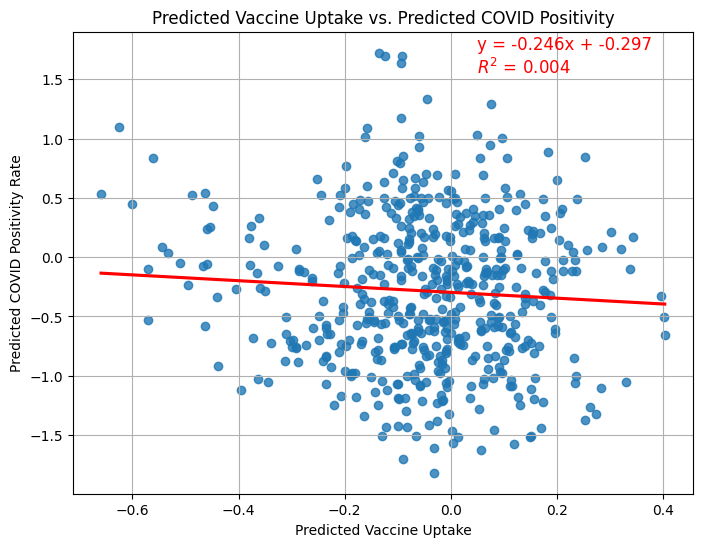


=== Statistical Results ===
Pearson Correlation (r): -0.0668
Correlation p-value: 1.2241e-01
Linear Regression Slope: -0.2456
Linear Regression Intercept: -0.2967
Linear Regression R²: 0.0045
Regression p-value: 1.2241e-01


In [38]:
# First, reset index to align
X_vaccine_test = X_vaccine_test.reset_index(drop=True)
X_test_positive_test = X_test_positive_test.reset_index(drop=True)

# Make sure minimum length
min_len = min(len(vaccine_preds), len(covid_preds))

# Trim predictions to the same size
vaccine_preds = vaccine_preds[:min_len]
covid_preds = covid_preds[:min_len]

# Now combine
combined_predictions = pd.DataFrame({
    "Predicted_Vaccine_Uptake": vaccine_preds,
    "Predicted_COVID_Positivity": covid_preds
})

# --- Imports ---
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, linregress

# --- Scatter Plot with Regression Line ---
plt.figure(figsize=(8,6))
sns.regplot(
    x="Predicted_Vaccine_Uptake",
    y="Predicted_COVID_Positivity",
    data=combined_predictions,
    ci=None,
    line_kws={"color": "red"}
)
plt.title("Predicted Vaccine Uptake vs. Predicted COVID Positivity")
plt.xlabel("Predicted Vaccine Uptake")
plt.ylabel("Predicted COVID Positivity Rate")
plt.grid(True)

# --- Linear Regression ---
slope, intercept, r_value, p_value_reg, std_err = linregress(
    combined_predictions["Predicted_Vaccine_Uptake"],
    combined_predictions["Predicted_COVID_Positivity"]
)

# Add regression equation on plot
plt.text(
    0.05,
    0.9 * combined_predictions["Predicted_COVID_Positivity"].max(),
    f"y = {slope:.3f}x + {intercept:.3f}\n$R^2$ = {r_value**2:.3f}",
    fontsize=12,
    color="red"
)
plt.show()

# --- Pearson Correlation ---
correlation, p_value_corr = pearsonr(
    combined_predictions["Predicted_Vaccine_Uptake"],
    combined_predictions["Predicted_COVID_Positivity"]
)

# --- Print Statistical Results ---
print("\n=== Statistical Results ===")
print(f"Pearson Correlation (r): {correlation:.4f}")
print(f"Correlation p-value: {p_value_corr:.4e}")
print(f"Linear Regression Slope: {slope:.4f}")
print(f"Linear Regression Intercept: {intercept:.4f}")
print(f"Linear Regression R²: {r_value**2:.4f}")
print(f"Regression p-value: {p_value_reg:.4e}")


Relationship : **A very weak negative correlation** <br>
Understanding the predicted vaccine uptake for a specific area does not enable you to reliably forecast the COVID positivity rate for that same area, according to these models. The two factors seem to be largely independent of one another. <br>

The scatter plot visually reinforces this lack of relationship, displaying points that are spread across the graph without any clear pattern or trend line.

### Predictive Modeling: Neural Network Approach

In this section, we implement a neural network-based predictive modeling approach using PyTorch to forecast two important COVID-19 public health indicators:
- Vaccine uptake percentage
- COVID-19 test positivity rate

The neural network helps capture complex relationships between individual behaviors, beliefs, and COVID-related outcomes.

In [39]:
# ---------------------------
# Define Neural Network Model with PyTorch
# ---------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# --- Data Preparation (Time-Based Split) ---

# 1. Feature Selection
feature_cols = [
    'smoothed_wcli', 'smoothed_wtested_14d', 'smoothed_wwearing_mask',
    'smoothed_wothers_masked', 'smoothed_wwork_outside_home_1d',
    'smoothed_wlarge_event_1d', 'smoothed_wrestaurant_1d',
    'smoothed_wshop_1d', 'smoothed_wspent_time_1d',
    'smoothed_wpublic_transit_1d', 'smoothed_wworried_become_ill',
    'smoothed_wvaccine_likely_friends', 'smoothed_wvaccine_likely_who',
    'smoothed_wvaccine_likely_govt_health', 'smoothed_wvaccine_likely_politicians'
]

target_vaccine = 'smoothed_wcovid_vaccinated'
target_positive = 'smoothed_wtested_positive_14d'

# 2. Data Cleanup
full_data = df[feature_cols + [target_vaccine, target_positive, 'time_value']].dropna()

# 3. Sort by Time
full_data = full_data.sort_values('time_value').reset_index(drop=True)

# 4. Define Features and Targets
X = full_data[feature_cols]
y_vaccine = full_data[target_vaccine]
y_positive = full_data[target_positive]

# 5. Time-Based Train-Validation-Test Split (70% train, 15% validation, 15% test)
train_idx = int(0.7 * len(full_data))
val_idx = int(0.85 * len(full_data))

Using device: cuda


In [40]:
# Vaccine Uptake Target
X_train_vac, X_val_vac, X_test_vac = X.iloc[:train_idx], X.iloc[train_idx:val_idx], X.iloc[val_idx:]
y_train_vac, y_val_vac, y_test_vac = y_vaccine.iloc[:train_idx], y_vaccine.iloc[train_idx:val_idx], y_vaccine.iloc[val_idx:]

# COVID Positivity Target
X_train_pos, X_val_pos, X_test_pos = X.iloc[:train_idx], X.iloc[train_idx:val_idx], X.iloc[val_idx:]
y_train_pos, y_val_pos, y_test_pos = y_positive.iloc[:train_idx], y_positive.iloc[train_idx:val_idx], y_positive.iloc[val_idx:]

# 6. Feature Scaling (fit on training, transform on all)
from sklearn.preprocessing import StandardScaler

scaler_vac = StandardScaler()
X_train_vac_scaled = scaler_vac.fit_transform(X_train_vac)
X_val_vac_scaled = scaler_vac.transform(X_val_vac)
X_test_vac_scaled = scaler_vac.transform(X_test_vac)

scaler_pos = StandardScaler()
X_train_pos_scaled = scaler_pos.fit_transform(X_train_pos)
X_val_pos_scaled = scaler_pos.transform(X_val_pos)
X_test_pos_scaled = scaler_pos.transform(X_test_pos)

In [41]:
# --- Neural Network Model ---

class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        # Move model to available device
        self.to(device)

    def forward(self, x):
        return self.model(x)

In [42]:
def train_model(X_train, y_train, X_val, y_val, num_epochs=50, batch_size=64, early_stopping_patience=5):
    model = SimpleNN(X_train.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    loss_fn = nn.MSELoss()

    # Convert to PyTorch tensors and move to device
    tensor_X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    tensor_y_train = torch.tensor(y_train.values.reshape(-1,1), dtype=torch.float32).to(device)
    tensor_X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
    tensor_y_val = torch.tensor(y_val.values.reshape(-1,1), dtype=torch.float32).to(device)

    # Create data loaders
    train_dataset = TensorDataset(tensor_X_train, tensor_y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    train_losses = []
    val_losses = []
    val_rmse_values = []

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in tqdm(range(num_epochs), desc="Training Progress", ncols=100):
        # Training phase
        model.train()
        epoch_train_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = loss_fn(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(tensor_X_val)
            val_loss = loss_fn(val_outputs, tensor_y_val).item()
            val_losses.append(val_loss)

            # Calculate RMSE for validation set
            val_preds = val_outputs.cpu().numpy().flatten()
            current_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
            val_rmse_values.append(current_rmse)

            # Print progress every 10 epochs
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Val RMSE: {current_rmse:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Load best model based on validation loss
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, train_losses, val_losses, val_rmse_values

In [43]:
# Train Neural Net for Vaccine Uptake
print("\n--- Training Vaccine Uptake Model ---")
model_vac, train_losses_vac, val_losses_vac, val_rmse_vac = train_model(
    X_train_vac_scaled, y_train_vac, X_val_vac_scaled, y_val_vac
)

# Train Neural Net for COVID Positivity
print("\n--- Training COVID Positivity Model ---")
model_pos, train_losses_pos, val_losses_pos, val_rmse_pos = train_model(
    X_train_pos_scaled, y_train_pos, X_val_pos_scaled, y_val_pos
)


--- Training Vaccine Uptake Model ---


Training Progress:  24%|██████████▌                                 | 12/50 [00:01<00:04,  8.69it/s]

Epoch 10/50: Train Loss: 0.1977, Val Loss: 0.6695, Val RMSE: 0.8182


Training Progress:  42%|██████████████████▍                         | 21/50 [00:02<00:02,  9.72it/s]

Epoch 20/50: Train Loss: 0.1275, Val Loss: 0.5447, Val RMSE: 0.7380


Training Progress:  62%|███████████████████████████▎                | 31/50 [00:03<00:01, 10.69it/s]

Epoch 30/50: Train Loss: 0.0889, Val Loss: 0.4818, Val RMSE: 0.6941


Training Progress:  68%|█████████████████████████████▉              | 34/50 [00:04<00:01,  8.04it/s]


Early stopping at epoch 35

--- Training COVID Positivity Model ---


Training Progress:  24%|██████████▌                                 | 12/50 [00:01<00:03, 11.19it/s]

Epoch 10/50: Train Loss: 0.2738, Val Loss: 0.3918, Val RMSE: 0.6259


Training Progress:  38%|████████████████▋                           | 19/50 [00:01<00:03,  9.94it/s]

Epoch 20/50: Train Loss: 0.1825, Val Loss: 0.3770, Val RMSE: 0.6140
Early stopping at epoch 20


In [44]:
# --- Neural Network Evaluation ---

def evaluate_model(model, X, y, target_name="", set_name=""):
    model.eval()
    tensor_X = torch.tensor(X, dtype=torch.float32).to(device)
    with torch.no_grad():
        preds = model(tensor_X).cpu().detach().numpy().flatten()

    mae = mean_absolute_error(y, preds)
    rmse = np.sqrt(mean_squared_error(y, preds))
    r2 = r2_score(y, preds)

    print(f"{target_name} - {set_name} Results:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}\n")

    return preds, mae, rmse, r2

print("--- Evaluation Results ---")

# Evaluate on Validation Set
print("Validation Set Evaluation:")
_, val_mae_vac, val_rmse_vac_final, val_r2_vac = evaluate_model(
    model_vac, X_val_vac_scaled, y_val_vac, "Vaccine Uptake", "Validation"
)
_, val_mae_pos, val_rmse_pos_final, val_r2_pos = evaluate_model(
    model_pos, X_val_pos_scaled, y_val_pos, "COVID Positivity", "Validation"
)

# Evaluate on Test Set
print("Test Set Evaluation:")
y_pred_vac, test_mae_vac, test_rmse_vac, test_r2_vac = evaluate_model(
    model_vac, X_test_vac_scaled, y_test_vac, "Vaccine Uptake", "Test"
)
y_pred_pos, test_mae_pos, test_rmse_pos, test_r2_pos = evaluate_model(
    model_pos, X_test_pos_scaled, y_test_pos, "COVID Positivity", "Test"
)

--- Evaluation Results ---
Validation Set Evaluation:
Vaccine Uptake - Validation Results:
MAE: 0.5360
RMSE: 0.7016
R²: -0.3923

COVID Positivity - Validation Results:
MAE: 0.4920
RMSE: 0.6140
R²: 0.5724

Test Set Evaluation:
Vaccine Uptake - Test Results:
MAE: 0.8468
RMSE: 1.0292
R²: -2.0214

COVID Positivity - Test Results:
MAE: 0.5758
RMSE: 0.7288
R²: 0.2983



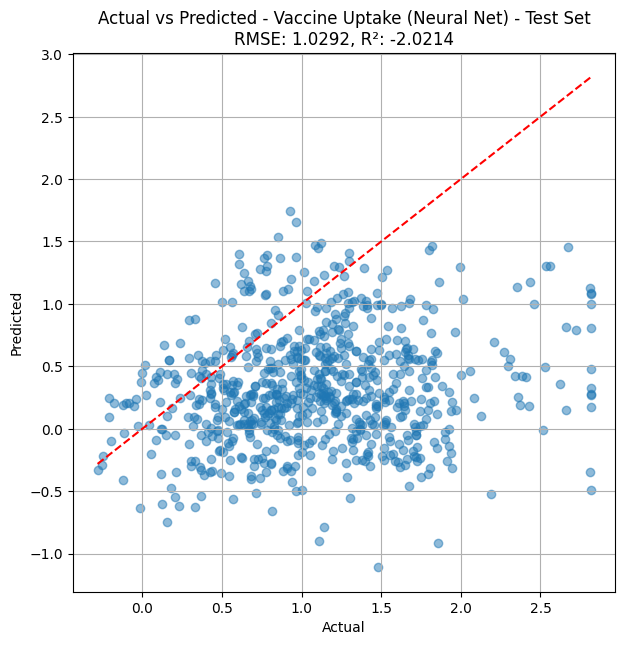

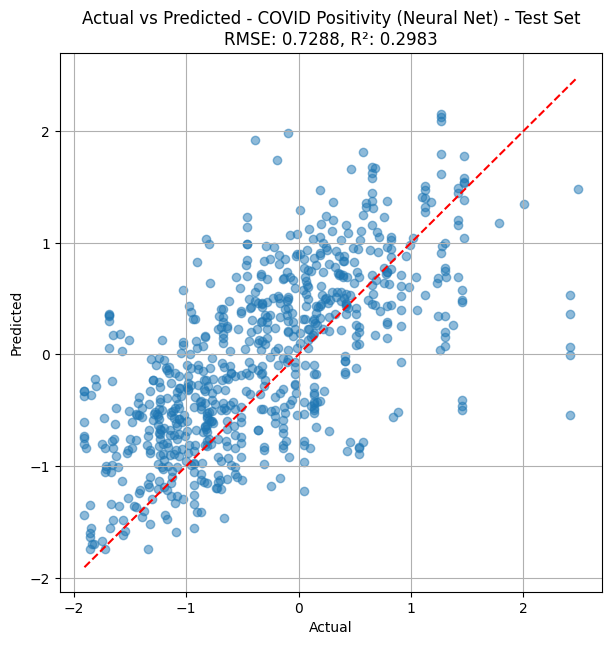

In [45]:
# --- Plot Actual vs Predicted ---

def plot_predicted_vs_actual(y_true, y_pred, title=""):
    plt.figure(figsize=(7,7))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # Ideal line
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f"{title}\nRMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}, R²: {r2_score(y_true, y_pred):.4f}")
    plt.grid(True)
    plt.show()

# Plot for Vaccine Uptake - Test Set
plot_predicted_vs_actual(
    y_test_vac, y_pred_vac,
    "Actual vs Predicted - Vaccine Uptake (Neural Net) - Test Set"
)

# Plot for COVID Positivity - Test Set
plot_predicted_vs_actual(
    y_test_pos, y_pred_pos,
    "Actual vs Predicted - COVID Positivity (Neural Net) - Test Set"
)

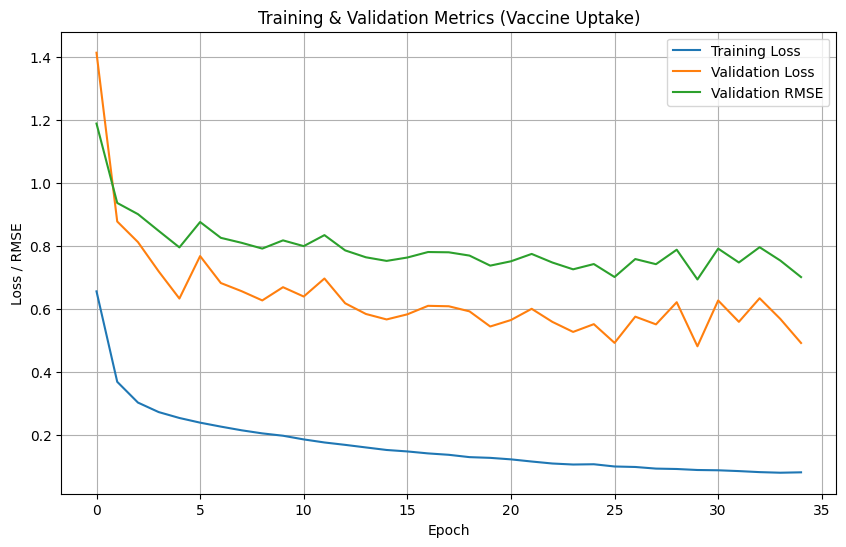

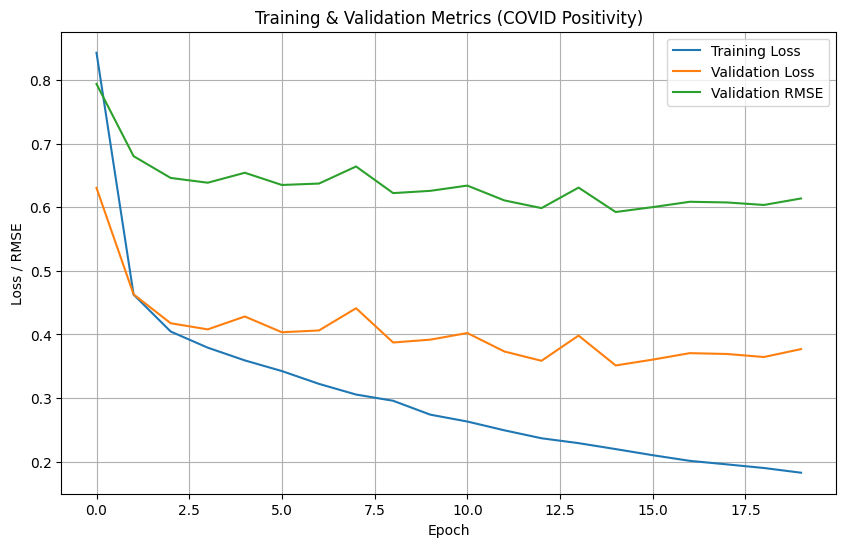

In [46]:
# --- Plot Training and Validation Loss vs Epochs ---

# Vaccine Uptake Loss Plot
plt.figure(figsize=(10,6))
plt.plot(train_losses_vac, label='Training Loss')
plt.plot(val_losses_vac, label='Validation Loss')
plt.plot(val_rmse_vac, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('Loss / RMSE')
plt.title('Training & Validation Metrics (Vaccine Uptake)')
plt.legend()
plt.grid(True)
plt.show()

# COVID Positivity Loss Plot
plt.figure(figsize=(10,6))
plt.plot(train_losses_pos, label='Training Loss')
plt.plot(val_losses_pos, label='Validation Loss')
plt.plot(val_rmse_pos, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('Loss / RMSE')
plt.title('Training & Validation Metrics (COVID Positivity)')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
# --- Print Summary Results Table ---
print("\n--- Summary of Model Performance ---")
print("Vaccine Uptake Model:")
print(f"Validation RMSE: {val_rmse_vac_final:.4f}, Validation R²: {val_r2_vac:.4f}")
print(f"Test RMSE: {test_rmse_vac:.4f}, Test R²: {test_r2_vac:.4f}")

print("\nCOVID Positivity Model:")
print(f"Validation RMSE: {val_rmse_pos_final:.4f}, Validation R²: {val_r2_pos:.4f}")
print(f"Test RMSE: {test_rmse_pos:.4f}, Test R²: {test_r2_pos:.4f}")


--- Summary of Model Performance ---
Vaccine Uptake Model:
Validation RMSE: 0.7016, Validation R²: -0.3923
Test RMSE: 1.0292, Test R²: -2.0214

COVID Positivity Model:
Validation RMSE: 0.6140, Validation R²: 0.5724
Test RMSE: 0.7288, Test R²: 0.2983


### Document and visualize key predictive relationships between predictors and your outcomes.

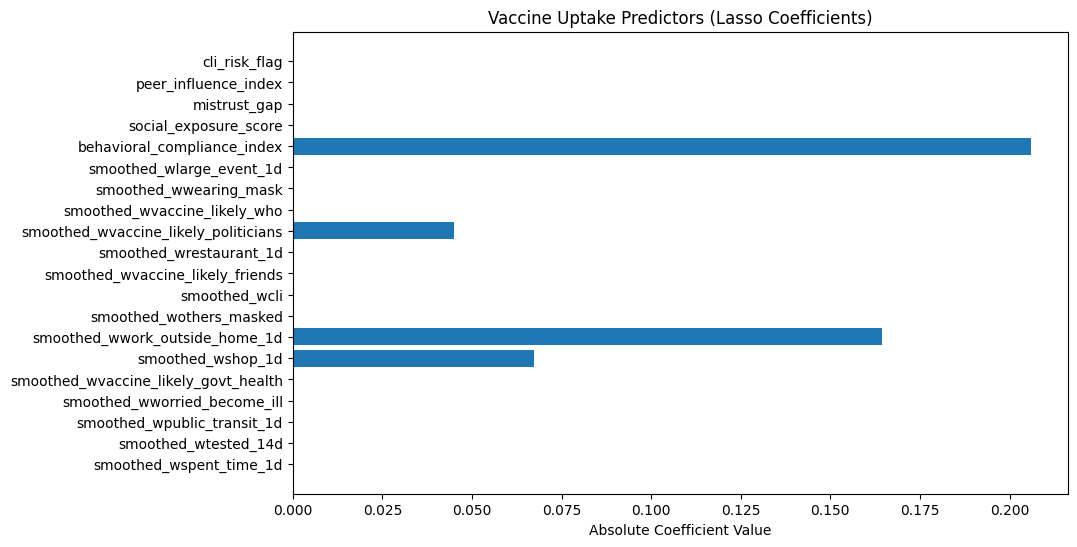

In [48]:
# Vaccine Uptake Model
vaccine_feature_names = X_vaccine_train.columns.values
plt.figure(figsize=(10,6))
plt.barh(vaccine_feature_names, np.abs(final_vaccine_model.coef_), color='#1f77b4')
plt.title('Vaccine Uptake Predictors (Lasso Coefficients)')
plt.xlabel('Absolute Coefficient Value');

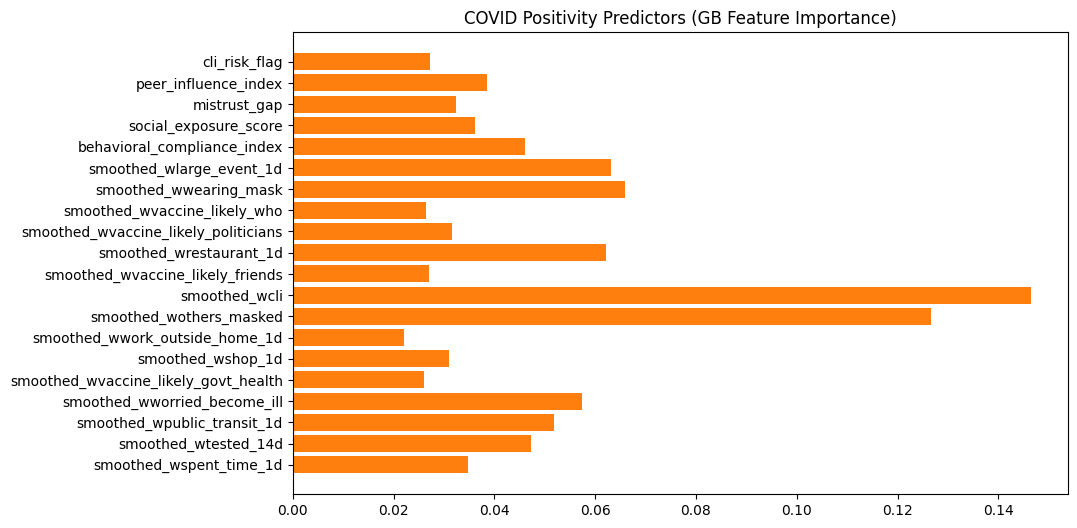

In [49]:
# COVID Test Positivity Model (Gradient Boosting)
covid_feature_names = X_test_positive_train.columns.values
plt.figure(figsize=(10,6))
plt.barh(covid_feature_names, final_covid_model.feature_importances_, color='#ff7f0e')
plt.title('COVID Positivity Predictors (GB Feature Importance)');